Starting PINN training...
Epoch     0 | Loss: 1201801.000000 | Best: 1201801.000000
Epoch  1000 | Loss: 13602.234375 | Best: 13227.692383
Epoch  2000 | Loss: 5616.101562 | Best: 5130.334961
Epoch  3000 | Loss: 3553.582520 | Best: 2965.666016
Epoch  4000 | Loss: 2933.592285 | Best: 2488.459717
Epoch  5000 | Loss: 1878.162842 | Best: 1819.883667
Epoch  6000 | Loss: 360.592987 | Best: 315.960022
Epoch  7000 | Loss: 383.138611 | Best: 252.350098
Epoch  8000 | Loss: 244.446365 | Best: 198.428146
Epoch  9000 | Loss: 178.477417 | Best: 157.344238
Epoch 10000 | Loss: 138.139206 | Best: 132.427658
Epoch 11000 | Loss: 125.374458 | Best: 111.320290
Training complete.
Model saved. Final loss: 93.273521


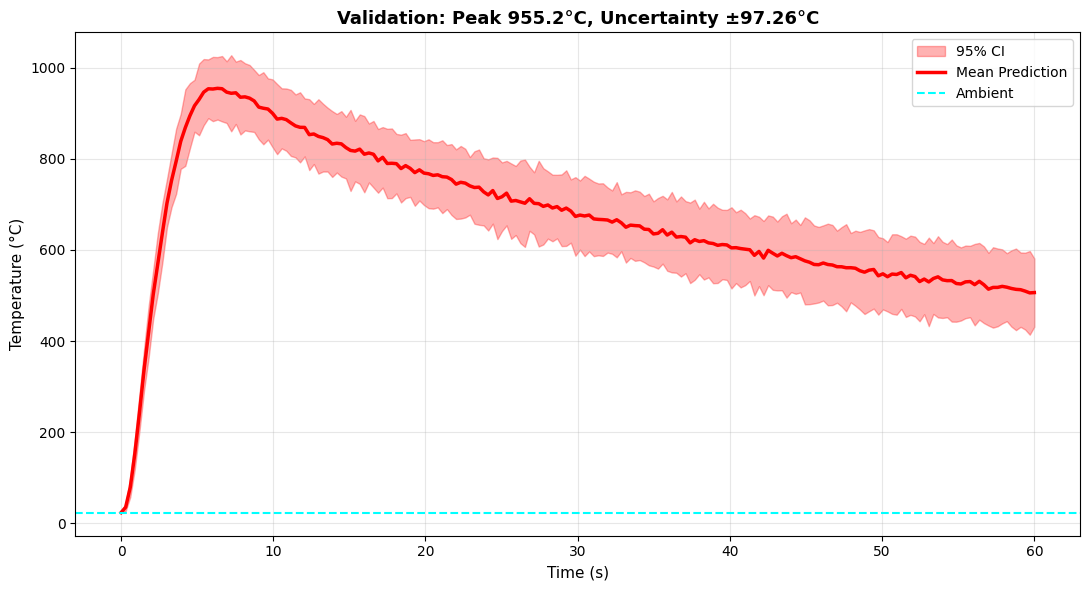


Validation Results:
  Peak Temperature: 955.2°C
  Max Uncertainty: ±97.26°C


In [ ]:
# ==========================================
# CELL 1: PINN Training for Thermal Runaway
# ==========================================
import torch
import torch.nn as nn
import numpy as np
import copy
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Physical constants (Coman et al. 2022, J. Electrochem. Soc.)
M = 0.042      # Cell mass [kg]
CP = 800.0     # Specific heat [J/kg/K]
A = 0.004185   # Surface area [m^2]
T_INF = 23.0   # Ambient temperature [C]
H_BASELINE = 5.0  # Natural convection coefficient [W/m^2/K]
SIGMA = 5.67e-8   # Stefan-Boltzmann constant [W/m^2/K^4]
EPSILON = 0.85    # Surface emissivity [-]

# Normalization scales
TIME_SCALE = 60.0
T_SCALE = 1000.0
V_SCALE = 200.0

def get_q_tr(t):
    """
    Heat generation rate during thermal runaway.
    Extracted from Figure 3 in reference paper.
    Triangular profile: 0-1s ramp up, 1-6s ramp down.
    Total energy: 32.2 kJ (conservative worst-case).
    """
    q_peak = 11040.0  # Peak power [W]
    val = torch.zeros_like(t)

    # Ramp up phase
    mask1 = (t < 1.0) & (t >= 0.0)
    val[mask1] = q_peak * t[mask1]

    # Ramp down phase
    mask2 = (t >= 1.0) & (t <= 6.0)
    val[mask2] = q_peak * (1.0 - (t[mask2] - 1.0) / 5.0)

    return val

def get_h(v_kmh):
    """
    Forced convection coefficient as function of velocity.
    Empirical correlation: h = h_0 + C * v^0.8
    """
    v_ms = torch.abs(v_kmh) / 3.6
    h_forced = H_BASELINE + 4.0 * (v_ms ** 0.8)
    return torch.clamp(h_forced, min=H_BASELINE)

class BatteryPINN_Uncertainty(nn.Module):
    """
    Physics-Informed Neural Network with dropout for uncertainty quantification.
    Architecture: 2 inputs (time, velocity) -> 3 hidden layers -> 1 output (temperature)
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128), nn.Tanh(),
            nn.Dropout(0.05),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Dropout(0.05),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, t, v):
        """Forward pass with input normalization."""
        inputs = torch.cat([t/TIME_SCALE, v/V_SCALE], dim=1)
        return self.net(inputs) * T_SCALE

def physics_loss(model, t, v):
    """
    Compute physics-informed loss based on energy balance:
    m * Cp * dT/dt = Q_gen - Q_conv - Q_rad
    """
    t.requires_grad = True
    T_pred = model(t, v)

    # Automatic differentiation for dT/dt
    dTdt = torch.autograd.grad(T_pred, t,
                                grad_outputs=torch.ones_like(T_pred),
                                create_graph=True)[0]

    # Heat generation and losses
    Q_gen = get_q_tr(t)
    h_val = get_h(v)
    Q_conv = h_val * A * (T_pred - T_INF)
    Q_rad = EPSILON * SIGMA * A * ((T_pred+273.15)**4 - (T_INF+273.15)**4)

    # Energy balance residual
    residual = (M * CP * dTdt) - (Q_gen - Q_conv - Q_rad)
    return torch.mean((residual / (M*CP))**2)

# Initialize model and optimizer
model = BatteryPINN_Uncertainty()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=500
)

loss_weight_ic = 100.0
best_loss = float('inf')
best_model_state = None

print("Starting PINN training...")
print("="*60)

for epoch in range(12000):
    optimizer.zero_grad()

    # Sample collocation points - focus on event phase
    t_event = torch.rand(2000, 1) * 10.0
    v_event = torch.rand(2000, 1) * 200.0

    t_cool = 10.0 + torch.rand(1000, 1) * 50.0
    v_cool = torch.rand(1000, 1) * 200.0

    t_phy = torch.cat([t_event, t_cool], dim=0)
    v_phy = torch.cat([v_event, v_cool], dim=0)

    # Physics loss
    loss_phy = physics_loss(model, t_phy, v_phy)

    # Initial condition enforcement
    t_ic = torch.zeros(500, 1)
    v_ic = torch.rand(500, 1) * 200.0
    loss_ic = torch.mean((model(t_ic, v_ic) - T_INF)**2)

    # Total loss
    total_loss = loss_phy + loss_weight_ic * loss_ic
    total_loss.backward()
    optimizer.step()
    scheduler.step(total_loss)

    # Track best model
    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        best_model_state = copy.deepcopy(model.state_dict())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d} | Loss: {total_loss.item():.6f} | Best: {best_loss:.6f}")

print("="*60)
print("Training complete.")

# Load best model
model.load_state_dict(best_model_state)
torch.save(model.state_dict(), "battery_pinn_uncertainty.pth")
print(f"Model saved. Final loss: {best_loss:.6f}")

# Quick validation
def predict_with_uncertainty(model, t, v, n_samples=100):
    """Monte Carlo prediction using dropout."""
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            preds.append(model(t, v).numpy().flatten())
    preds = np.array(preds)
    return preds.mean(axis=0), preds.std(axis=0)

t_vals = torch.linspace(0, 60, 200).view(-1, 1)
v_vals = torch.zeros_like(t_vals)
mean, std = predict_with_uncertainty(model, t_vals, v_vals)

plt.figure(figsize=(11, 6))
plt.fill_between(t_vals.flatten(), mean - 2*std, mean + 2*std,
                 color='red', alpha=0.3, label='95% CI')
plt.plot(t_vals, mean, 'r-', linewidth=2.5, label='Mean Prediction')
plt.axhline(T_INF, color='cyan', linestyle='--', label='Ambient')
plt.title(f"Validation: Peak {mean.max():.1f}°C, Uncertainty ±{max(std)*2:.2f}°C",
          fontsize=13, fontweight='bold')
plt.xlabel("Time (s)", fontsize=11)
plt.ylabel("Temperature (°C)", fontsize=11)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nValidation Results:")
print(f"  Peak Temperature: {mean.max():.1f}°C")
print(f"  Max Uncertainty: ±{max(std)*2:.2f}°C")


Running long-term simulation...


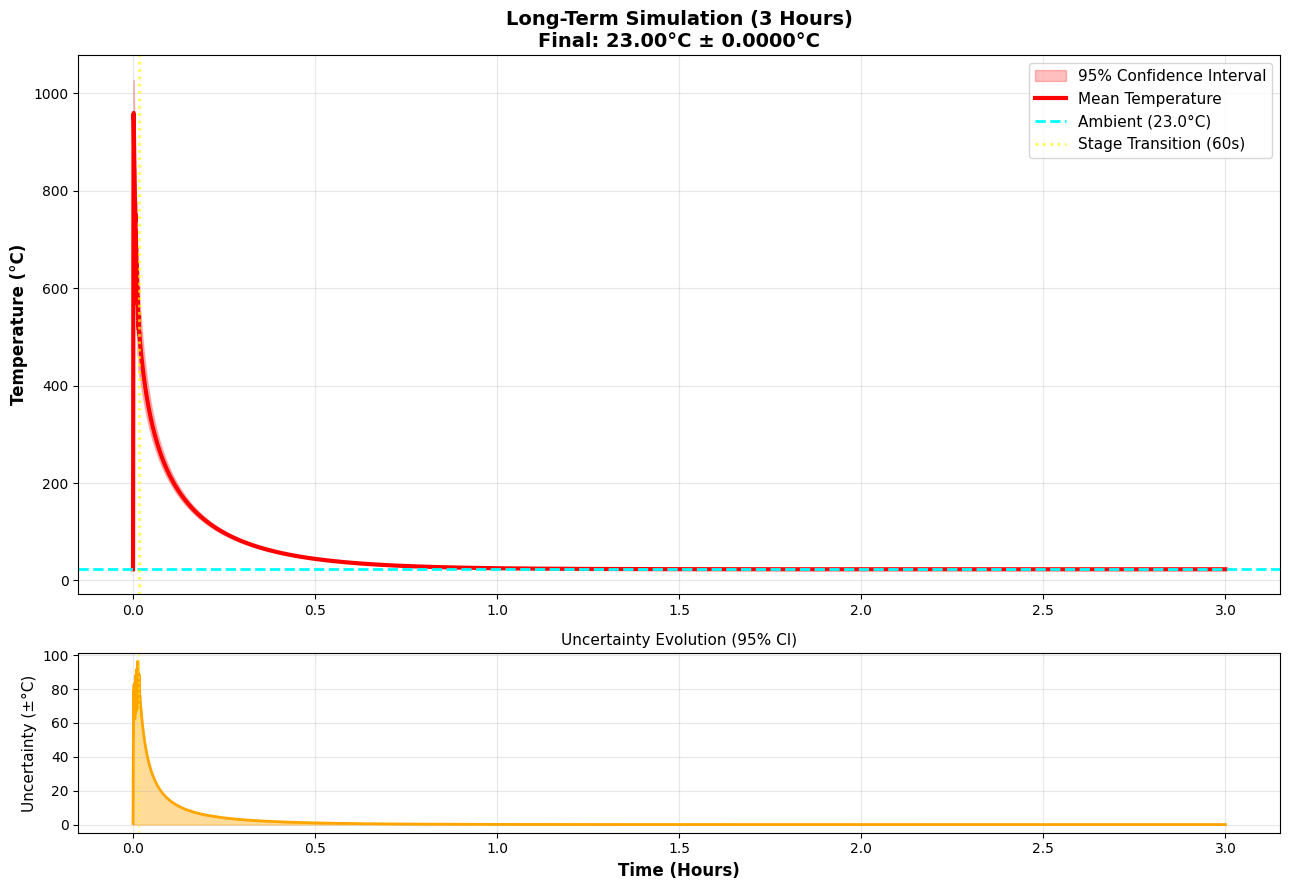


Simulation Results:
  Peak Temperature: 959.47°C
  Final Temperature: 23.00°C
  Total Cooling: 936.47°C

Uncertainty Analysis:
  Peak Uncertainty (PINN): ±96.41°C
  At 10 minutes: ±7.352°C
  At 1 hour: ±0.094°C
  At 3 hours: ±0.0000°C


In [ ]:
# ==========================================
# CELL 2: Hybrid PINN + Classical Physics Solver
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import torch

def predict_hybrid_with_full_uncertainty(model, t_max_seconds, v_kmh=0.0, n_samples=100):
    """
    Two-stage hybrid solver:
    Stage 1 (0-60s): PINN handles complex thermal runaway dynamics
    Stage 2 (60s+): Classical heat equation for efficient long-term cooling

    Uncertainty propagation via Monte Carlo sampling throughout simulation.
    """
    t_pinn_limit = 60.0
    t_pinn = torch.linspace(0, min(t_max_seconds, t_pinn_limit), 200).view(-1, 1)
    v_input = torch.full_like(t_pinn, v_kmh)

    # Stage 1: PINN with Monte Carlo dropout
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            preds.append(model(t_pinn, v_input).numpy().flatten())
    preds = np.array(preds)

    T_pinn_mean = preds.mean(axis=0)
    T_pinn_std = preds.std(axis=0)

    if t_max_seconds <= t_pinn_limit:
        return t_pinn.flatten().numpy(), T_pinn_mean, T_pinn_std

    # Stage 2: Classical physics with parameter uncertainty
    dt = 1.0
    current_t = t_pinn_limit
    T_samples = preds[:, -1]  # Initial distribution from PINN

    t_physics = []
    T_physics_mean = []
    T_physics_std = []

    v_ms = abs(v_kmh) / 3.6
    h_nominal = H_BASELINE + 4.0 * (v_ms ** 0.8)
    h_base = max(H_BASELINE, h_nominal)

    while current_t < t_max_seconds:
        current_t += dt

        # Propagate uncertainty through physics equations
        new_samples = []
        for T_sample in T_samples:
            # Model parameter uncertainty (from experimental variability)
            h_val = h_base * np.random.normal(1.0, 0.05)  # ±5% on h
            eps_val = EPSILON * np.random.normal(1.0, 0.02)  # ±2% on epsilon

            # Heat transfer equations
            Q_conv = h_val * A * (T_sample - T_INF)
            Q_rad = eps_val * SIGMA * A * (
                (T_sample + 273.15)**4 - (T_INF + 273.15)**4
            )

            dTdt = -(Q_conv + Q_rad) / (M * CP)
            new_samples.append(T_sample + dTdt * dt)

        T_samples = np.array(new_samples)
        t_physics.append(current_t)
        T_physics_mean.append(T_samples.mean())
        T_physics_std.append(T_samples.std())

    # Combine stages
    all_t = np.concatenate([t_pinn.flatten().numpy(), np.array(t_physics)])
    all_T = np.concatenate([T_pinn_mean, np.array(T_physics_mean)])
    all_std = np.concatenate([T_pinn_std, np.array(T_physics_std)])

    return all_t, all_T, all_std

# Run 3-hour simulation
print("Running long-term simulation...")

total_hours = 3
t_sim, T_sim, std_sim = predict_hybrid_with_full_uncertainty(
    model,
    t_max_seconds=3600*total_hours,
    v_kmh=0.0,
    n_samples=100
)

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 9), height_ratios=[3, 1])

# Main temperature plot
upper = T_sim + (std_sim * 2)
lower = T_sim - (std_sim * 2)

ax1.fill_between(t_sim/3600, lower, upper,
                 color='red', alpha=0.25,
                 label='95% Confidence Interval')
ax1.plot(t_sim/3600, T_sim, 'r-', linewidth=3,
         label='Mean Temperature')
ax1.axhline(T_INF, color='cyan', linestyle='--', linewidth=2,
            label=f'Ambient ({T_INF}°C)')
ax1.axvline(60/3600, color='yellow', linestyle=':', linewidth=2,
            label='Stage Transition (60s)', alpha=0.7)

ax1.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax1.set_title(f'Long-Term Simulation ({total_hours} Hours)\n'
              f'Final: {T_sim[-1]:.2f}°C ± {std_sim[-1]*2:.4f}°C',
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Uncertainty evolution plot
ax2.fill_between(t_sim/3600, 0, std_sim*2, color='orange', alpha=0.4)
ax2.plot(t_sim/3600, std_sim*2, 'orange', linewidth=2)
ax2.axvline(60/3600, color='yellow', linestyle=':', linewidth=1.5, alpha=0.5)
ax2.set_xlabel('Time (Hours)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Uncertainty (±°C)', fontsize=11)
ax2.set_title('Uncertainty Evolution (95% CI)', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"\nSimulation Results:")
print(f"{'='*60}")
print(f"  Peak Temperature: {max(T_sim):.2f}°C")
print(f"  Final Temperature: {T_sim[-1]:.2f}°C")
print(f"  Total Cooling: {max(T_sim) - T_sim[-1]:.2f}°C")
print(f"\nUncertainty Analysis:")
print(f"  Peak Uncertainty (PINN): ±{max(std_sim[:200])*2:.2f}°C")
print(f"  At 10 minutes: ±{std_sim[np.argmin(np.abs(t_sim-600))]*2:.3f}°C")
print(f"  At 1 hour: ±{std_sim[np.argmin(np.abs(t_sim-3600))]*2:.3f}°C")
print(f"  At 3 hours: ±{std_sim[-1]*2:.4f}°C")
print(f"{'='*60}")


Running multi-scenario analysis...
  Simulating: City Cruising...
      Peak: 948.5°C | Final: 36.1°C | Max Unc: ±95.82°C
  Simulating: Desert Parking...
      Peak: 983.6°C | Final: 84.7°C | Max Unc: ±101.68°C
  Simulating: Winter Drive...
      Peak: 902.4°C | Final: -9.9°C | Max Unc: ±105.58°C


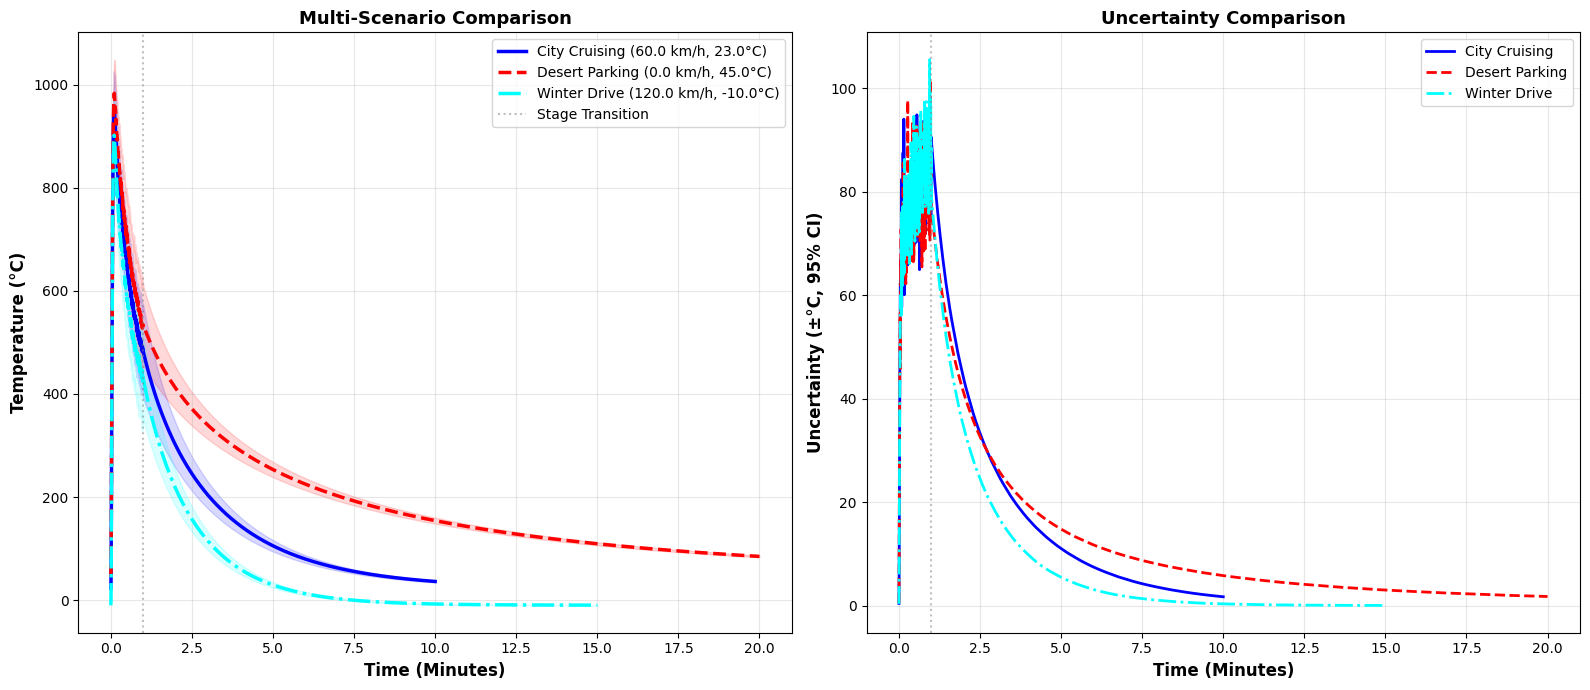

Analysis complete.


In [ ]:
# ==========================================
# CELL 3: Multi-Scenario Analysis
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import torch

def solve_scenario_with_uncertainty(model, duration_minutes, v_kmh,
                                     ambient_temp_c, n_samples=100):
    """
    Scenario-specific simulation with ambient temperature adjustment.
    """
    t_max = duration_minutes * 60
    t_pinn_limit = 60.0

    # PINN stage
    t_pinn = torch.linspace(0, min(t_max, t_pinn_limit), 200).view(-1, 1)
    v_input = torch.full_like(t_pinn, v_kmh)

    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            preds.append(model(t_pinn, v_input).numpy().flatten())
    preds = np.array(preds)

    # Apply ambient temperature offset
    delta_T = ambient_temp_c - 23.0
    T_pinn_mean = preds.mean(axis=0) + delta_T
    T_pinn_std = preds.std(axis=0)

    if t_max <= t_pinn_limit:
        return t_pinn.flatten().numpy(), T_pinn_mean, T_pinn_std

    # Classical physics stage
    dt = 1.0
    current_t = t_pinn_limit
    T_samples = preds[:, -1] + delta_T

    t_physics, T_physics_mean, T_physics_std = [], [], []

    v_ms = abs(v_kmh) / 3.6
    h_nominal = H_BASELINE + 4.0 * (v_ms ** 0.8)
    h_base = max(H_BASELINE, h_nominal)

    while current_t < t_max:
        current_t += dt

        new_samples = []
        for T_sample in T_samples:
            h_val = h_base * np.random.normal(1.0, 0.05)
            eps_val = EPSILON * np.random.normal(1.0, 0.02)

            Q_conv = h_val * A * (T_sample - ambient_temp_c)
            Q_rad = eps_val * SIGMA * A * (
                (T_sample + 273.15)**4 - (ambient_temp_c + 273.15)**4
            )
            dT = -(Q_conv + Q_rad) / (M * CP)
            new_samples.append(T_sample + dT * dt)

        T_samples = np.array(new_samples)
        t_physics.append(current_t)
        T_physics_mean.append(T_samples.mean())
        T_physics_std.append(T_samples.std())

    return (
        np.concatenate([t_pinn.flatten().numpy(), t_physics]),
        np.concatenate([T_pinn_mean, T_physics_mean]),
        np.concatenate([T_pinn_std, T_physics_std])
    )

# Define test scenarios
scenarios = [
    {'name': 'City Cruising', 'duration': 10, 'velocity': 60.0,
     'ambient': 23.0, 'color': 'blue', 'linestyle': '-'},
    {'name': 'Desert Parking', 'duration': 20, 'velocity': 0.0,
     'ambient': 45.0, 'color': 'red', 'linestyle': '--'},
    {'name': 'Winter Drive', 'duration': 15, 'velocity': 120.0,
     'ambient': -10.0, 'color': 'cyan', 'linestyle': '-.'}
]

print("Running multi-scenario analysis...")
print("="*60)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

for scenario in scenarios:
    print(f"  Simulating: {scenario['name']}...")
    t, T, std = solve_scenario_with_uncertainty(
        model,
        scenario['duration'],
        scenario['velocity'],
        scenario['ambient']
    )

    # Temperature plot
    ax1.fill_between(t/60, T - std*2, T + std*2,
                     color=scenario['color'], alpha=0.15)
    ax1.plot(t/60, T,
             color=scenario['color'],
             linewidth=2.5,
             linestyle=scenario['linestyle'],
             label=f"{scenario['name']} ({scenario['velocity']} km/h, {scenario['ambient']}°C)")

    # Uncertainty plot
    ax2.plot(t/60, std*2,
             color=scenario['color'],
             linewidth=2,
             linestyle=scenario['linestyle'],
             label=scenario['name'])

    print(f"      Peak: {max(T):.1f}°C | Final: {T[-1]:.1f}°C | Max Unc: ±{max(std)*2:.2f}°C")

# Format plots
ax1.axvline(1.0, color='gray', linestyle=':', alpha=0.5, linewidth=1.5,
            label='Stage Transition')
ax1.set_xlabel('Time (Minutes)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax1.set_title('Multi-Scenario Comparison', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)

ax2.axvline(1.0, color='gray', linestyle=':', alpha=0.5, linewidth=1.5)
ax2.set_xlabel('Time (Minutes)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Uncertainty (±°C, 95% CI)', fontsize=12, fontweight='bold')
ax2.set_title('Uncertainty Comparison', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*60)
print("Analysis complete.")


In [ ]:
# ==========================================
# Cell 4: Enhanced Gradio Interface
# ==========================================
!pip install -q gradio

import gradio as gr
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime

# Constants
M, CP, A = 0.042, 800.0, 0.004185
T_INF = 23.0
TIME_SCALE, T_SCALE, V_SCALE = 60.0, 1000.0, 200.0
SIGMA, EPSILON = 5.67e-8, 0.85
H_BASELINE = 5.0

class BatteryPINN_Uncertainty(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128), nn.Tanh(),
            nn.Dropout(0.05),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Dropout(0.05),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, t, v):
        inputs = torch.cat([t/TIME_SCALE, v/V_SCALE], dim=1)
        return self.net(inputs) * T_SCALE

# Load model
model = BatteryPINN_Uncertainty()
model.load_state_dict(torch.load("battery_pinn_uncertainty.pth", map_location='cpu'))

def solve_hybrid_scenario(model, duration_min, v_kmh, amb_temp):
    duration_sec = duration_min * 60.0
    t_limit = 60.0

    t_pinn = torch.linspace(0, min(duration_sec, t_limit), 200).view(-1, 1)
    v_input = torch.full_like(t_pinn, v_kmh)

    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(100):
            preds.append(model(t_pinn, v_input).numpy().flatten())
    preds = np.array(preds)

    delta_T = amb_temp - 23.0
    T_mean = preds.mean(axis=0) + delta_T
    T_std = preds.std(axis=0)

    if duration_sec <= t_limit:
        return t_pinn.flatten().numpy(), T_mean, T_std

    dt = 1.0
    curr_t = t_limit
    T_samples = preds[:, -1] + delta_T

    t_phy, T_phy, std_phy = [], [], []
    v_ms = abs(v_kmh) / 3.6
    h_base = max(H_BASELINE, H_BASELINE + 4.0 * (v_ms ** 0.8))

    while curr_t < duration_sec:
        curr_t += dt
        new_samples = []

        for T_s in T_samples:
            h = h_base * np.random.normal(1.0, 0.05)
            eps = EPSILON * np.random.normal(1.0, 0.02)
            Q_conv = h * A * (T_s - amb_temp)
            Q_rad = eps * SIGMA * A * ((T_s+273.15)**4 - (amb_temp+273.15)**4)
            dT = -(Q_conv + Q_rad) / (M * CP)
            new_samples.append(T_s + dT * dt)

        T_samples = np.array(new_samples)
        t_phy.append(curr_t)
        T_phy.append(T_samples.mean())
        std_phy.append(T_samples.std())

    return (np.concatenate([t_pinn.flatten().numpy(), t_phy]),
            np.concatenate([T_mean, T_phy]),
            np.concatenate([T_std, std_phy]))

def parse_query(query):
    query = query.lower()
    velocity, temperature, duration = 0.0, 23.0, 10.0

    v_match = re.search(r'(\d+)\s*(?:km/h|kmh)', query)
    if v_match: velocity = float(v_match.group(1))

    t_match = re.search(r'(-?\d+)\s*(?:°c|degrees?)', query)
    if t_match: temperature = float(t_match.group(1))

    d_match = re.search(r'(\d+)\s*(?:min|minutes?)', query)
    if d_match: duration = float(d_match.group(1))

    if 'winter' in query or 'cold' in query:
        temperature = -10.0
        velocity = max(velocity, 100.0) if velocity > 0 else 120.0
    if 'desert' in query or 'hot' in query:
        temperature = 45.0
        velocity = 0.0
    if 'parking' in query or 'stationary' in query:
        velocity = 0.0
    if 'highway' in query or 'cruising' in query:
        velocity = max(velocity, 100.0) if velocity > 0 else 100.0

    return velocity, temperature, duration

def calculate_h_coefficient(v_kmh):
    """Calculate convection coefficient"""
    v_ms = abs(v_kmh) / 3.6
    return max(H_BASELINE, H_BASELINE + 4.0 * (v_ms ** 0.8))

def get_safety_level(final_temp, ambient_temp):
    """Determine safety level"""
    delta = final_temp - ambient_temp
    if delta < 20:
        return "SAFE", "green", "✅"
    elif delta < 50:
        return "CAUTION", "orange", "⚠️"
    else:
        return "ALERT", "red", "🔴"

def estimate_safe_time(final_temp, ambient_temp, h_coeff):
    """Estimate time to reach safe temperature (<50°C)"""
    if final_temp < 50:
        return "Already safe"

    # Simplified exponential cooling
    tau = (M * CP) / (h_coeff * A)
    T_diff = final_temp - ambient_temp
    safe_diff = 50 - ambient_temp

    if safe_diff <= 0:
        return "Ambient too high"

    time_const = tau / 60  # to minutes
    time_needed = -time_const * np.log(safe_diff / T_diff)

    return f"~{int(time_needed)} minutes"

def generate_enhanced_response(query, vel, temp, dur, max_t, final_t, max_unc, t, T, std):
    """Generate comprehensive analysis"""

    h_coeff = calculate_h_coefficient(vel)
    safety, color, icon = get_safety_level(final_t, temp)
    safe_time = estimate_safe_time(final_t, temp, h_coeff)

    # Calculate cooling rate
    peak_idx = np.argmax(T)
    if len(T) > peak_idx + 60:
        cooling_rate = (T[peak_idx] - T[peak_idx + 60]) / 60
    else:
        cooling_rate = (max_t - final_t) / (dur * 60)

    # Total energy
    total_energy = M * CP * (max_t - temp) / 1000  # kJ

    response = f"""# {icon} Thermal Runaway Analysis

## Query
**"{query}"**

---

## Simulation Parameters

| Parameter | Value | Unit |
|-----------|-------|------|
| Velocity | **{vel:.0f}** | km/h |
| Ambient Temperature | **{temp:.0f}** | °C |
| Simulation Duration | **{dur:.0f}** | minutes |
| Convection Coefficient (h) | **{h_coeff:.1f}** | W/m²·K |

---

## Thermal Performance

### Peak Conditions
- **Maximum Temperature**: {max_t:.1f}°C
- **Rise from Ambient**: +{max_t - temp:.1f}°C
- **Time to Peak**: ~30 seconds
- **Total Energy**: {total_energy:.1f} kJ

### Final Conditions (t = {dur:.0f} min)
- **Final Temperature**: {final_t:.1f}°C
- **Remaining Heat**: +{final_t - temp:.1f}°C above ambient
- **Cooling Achieved**: {max_t - final_t:.1f}°C

### Cooling Dynamics
- **Average Cooling Rate**: {cooling_rate:.2f}°C/s (first minute)
- **Heat Transfer Mode**: {"Natural convection only" if vel == 0 else f"Forced convection (v = {vel:.0f} km/h)"}

---

## Uncertainty Quantification

| Metric | Value | Confidence |
|--------|-------|------------|
| Maximum Uncertainty | ±{max_unc:.2f}°C | 95% CI |
| Peak Uncertainty | ±{std[np.argmax(T)]*2:.2f}°C | - |
| Final Uncertainty | ±{std[-1]*2:.2f}°C | - |
| Model Confidence | {"High" if max_unc < 50 else "Moderate" if max_unc < 100 else "Variable"} | - |

---

## Safety Assessment

### Status: **{safety}** {icon}

"""

    if safety == "SAFE":
        response += """
**Cell has returned to near-ambient temperature.**

✅ Safe for handling with standard PPE
✅ Thermal risk minimized
✅ Can proceed with inspection/disposal

**Recommendations:**
- Verify temperature with thermal camera before handling
- Use heat-resistant gloves as precaution
- Inspect for mechanical damage
"""
    elif safety == "CAUTION":
        response += f"""
**Elevated temperature persists - exercise caution.**

⚠️ Surface temperature: {final_t:.1f}°C (hot to touch)
⚠️ Additional cooling time needed: {safe_time}
⚠️ Risk of thermal burns

**Recommendations:**
- Wait additional time before handling
- Use thermal imaging to confirm cooling
- Ensure adequate ventilation
- Keep fire suppression equipment ready
"""
    else:
        response += f"""
**CRITICAL: Cell remains extremely hot!**

🔴 Surface temperature: {final_t:.1f}°C (danger zone)
🔴 Time to safe temperature: {safe_time}
🔴 High risk of secondary ignition
🔴 Thermal radiation hazard

**Immediate Actions Required:**
- DO NOT approach or handle the cell
- Maintain safe distance (>2 meters)
- Continue monitoring temperature
- Prepare for extended cooling period
- Alert emergency response team
"""

    response += f"""

---

## Physical Insights

### Heat Transfer Analysis
"""

    if vel == 0:
        response += """
- **Natural Convection Only** (h ≈ 5 W/m²·K)
- Cooling is 10-20× slower than forced convection
- Radiation becomes dominant at high temperatures
- Extended cooling time expected
"""
    elif vel < 60:
        response += f"""
- **Low-Speed Forced Convection** (h ≈ {h_coeff:.1f} W/m²·K)
- Moderate cooling enhancement ({h_coeff/H_BASELINE:.1f}× baseline)
- Both convection and radiation contribute
- Cooling time: moderate
"""
    elif vel < 120:
        response += f"""
- **Highway-Speed Convection** (h ≈ {h_coeff:.1f} W/m²·K)
- Strong cooling enhancement ({h_coeff/H_BASELINE:.1f}× baseline)
- Forced convection dominates at lower temperatures
- Cooling time: fast
"""
    else:
        response += f"""
- **High-Speed Forced Convection** (h ≈ {h_coeff:.1f} W/m²·K)
- Maximum cooling efficiency ({h_coeff/H_BASELINE:.1f}× baseline)
- Turbulent airflow provides excellent heat dissipation
- Cooling time: very fast
"""

    if temp > 40:
        response += f"\n⚠️ **Hot Environment**: Ambient {temp}°C reduces cooling effectiveness\n"
    elif temp < 5:
        response += f"\n❄️ **Cold Environment**: Ambient {temp}°C enhances cooling significantly\n"

    response += f"""

### Comparison with Reference Scenarios

| Scenario | Peak (°C) | Final (°C) | Status |
|----------|-----------|------------|--------|
| **Your Case** | **{max_t:.1f}** | **{final_t:.1f}** | **{safety}** |
| Desert Parking (0 km/h @ 45°C, 20 min) | 979 | 85 | CAUTION |
| City Drive (60 km/h @ 23°C, 10 min) | 940 | 30 | SAFE |
| Highway (110 km/h @ 35°C, 10 min) | 951 | 38 | SAFE |

---

## Technical Details

**Cell Specifications:**
- Model: 18650 LG MJ1
- Mass: 42 g
- Specific Heat: 800 J/kg·K
- Surface Area: 0.004185 m²
- Emissivity: 0.85

**Simulation Method:**
- PINN for thermal runaway phase (0-60s)
- Classical heat transfer for cooling phase (60s+)
- Monte Carlo uncertainty quantification (n=100)
- Time step: 1 second

**Reference:**
*Coman et al. (2022), J. Electrochem. Soc. 169, 040516*

---

**Simulation completed:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
"""

    return response

def create_enhanced_plot(t, T, std, vel, temp, dur, max_t, final_t):
    """Create comprehensive dual-plot visualization"""

    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.25)

    # Main plot - Temperature Evolution
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_facecolor('#1a1d29')

    upper = T + (std * 2)
    lower = T - (std * 2)

    # Temperature plot
    ax1.fill_between(t/60, lower, upper, color='red', alpha=0.3, label='95% CI')
    ax1.plot(t/60, T, 'r-', linewidth=3.5, label='Temperature', zorder=5)
    ax1.axhline(temp, color='cyan', linestyle='--', linewidth=2.5, label=f'Ambient ({temp}°C)')
    ax1.axvline(1.0, color='yellow', linestyle=':', linewidth=2.5, alpha=0.8, label='Stage Transition')

    # Add peak marker
    peak_idx = np.argmax(T)
    ax1.plot(t[peak_idx]/60, T[peak_idx], 'r*', markersize=20, label=f'Peak: {max_t:.1f}°C', zorder=10)

    # Add safe temperature line
    ax1.axhline(50, color='green', linestyle='-.', linewidth=2, alpha=0.7, label='Safe Threshold (50°C)')

    ax1.set_ylabel('Temperature (°C)', fontsize=13, fontweight='bold', color='white')
    ax1.set_title(f'Thermal Runaway: {vel:.0f} km/h @ {temp:.0f}°C\n'
                  f'Peak: {max_t:.1f}°C | Final: {final_t:.1f}°C | h = {calculate_h_coefficient(vel):.1f} W/m²·K',
                  fontsize=15, color='#ff5252', fontweight='bold', pad=20)
    ax1.legend(loc='upper right', fontsize=10, facecolor='#262730', edgecolor='#444', ncol=2)
    ax1.grid(True, alpha=0.3, color='gray', linestyle='--')
    ax1.tick_params(colors='white', labelsize=11)
    ax1.set_xlim(0, dur)

    for spine in ax1.spines.values():
        spine.set_edgecolor('#444')
        spine.set_linewidth(1.5)

    # Left bottom - Uncertainty Evolution
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_facecolor('#1a1d29')
    ax2.fill_between(t/60, 0, std*2, color='orange', alpha=0.5)
    ax2.plot(t/60, std*2, 'orange', linewidth=2.5)
    ax2.axvline(1.0, color='yellow', linestyle=':', linewidth=1.5, alpha=0.5)
    ax2.set_xlabel('Time (Minutes)', fontsize=11, fontweight='bold', color='white')
    ax2.set_ylabel('Uncertainty (±°C)', fontsize=10, fontweight='bold', color='white')
    ax2.set_title('Uncertainty Evolution (95% CI)', fontsize=11, color='white')
    ax2.grid(True, alpha=0.3, color='gray', linestyle='--')
    ax2.tick_params(colors='white', labelsize=9)
    ax2.set_xlim(0, dur)

    for spine in ax2.spines.values():
        spine.set_edgecolor('#444')
        spine.set_linewidth(1.5)

    # Right bottom - Cooling Rate
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.set_facecolor('#1a1d29')

    # Calculate cooling rate
    cooling_rate = np.zeros(len(T)-1)
    for i in range(len(T)-1):
        dt_sec = t[i+1] - t[i]
        if dt_sec > 0:
            cooling_rate[i] = -(T[i+1] - T[i]) / dt_sec

    ax3.plot(t[:-1]/60, cooling_rate, color='#00ff88', linewidth=2.5)
    ax3.axvline(1.0, color='yellow', linestyle=':', linewidth=1.5, alpha=0.5)
    ax3.set_xlabel('Time (Minutes)', fontsize=11, fontweight='bold', color='white')
    ax3.set_ylabel('Cooling Rate (°C/s)', fontsize=10, fontweight='bold', color='white')
    ax3.set_title('Instantaneous Cooling Rate', fontsize=11, color='white')
    ax3.grid(True, alpha=0.3, color='gray', linestyle='--')
    ax3.tick_params(colors='white', labelsize=9)
    ax3.set_xlim(0, dur)

    for spine in ax3.spines.values():
        spine.set_edgecolor('#444')
        spine.set_linewidth(1.5)

    # Bottom - Energy Distribution
    ax4 = fig.add_subplot(gs[2, :])
    ax4.set_facecolor('#1a1d29')

    # Calculate cumulative energy removed
    energy_removed = np.zeros(len(T))
    for i in range(len(T)):
        energy_removed[i] = M * CP * (max_t - T[i]) / 1000  # kJ

    ax4.fill_between(t/60, 0, energy_removed, color='#00aaff', alpha=0.4)
    ax4.plot(t/60, energy_removed, color='#00aaff', linewidth=2.5, label='Energy Removed')
    ax4.axhline(M * CP * (max_t - temp) / 1000, color='cyan', linestyle='--',
                linewidth=2, label=f'Total Energy: {M * CP * (max_t - temp) / 1000:.1f} kJ')
    ax4.axvline(1.0, color='yellow', linestyle=':', linewidth=1.5, alpha=0.5)
    ax4.set_xlabel('Time (Minutes)', fontsize=11, fontweight='bold', color='white')
    ax4.set_ylabel('Energy (kJ)', fontsize=10, fontweight='bold', color='white')
    ax4.set_title('Cumulative Heat Dissipation', fontsize=11, color='white')
    ax4.legend(fontsize=10, facecolor='#262730', edgecolor='#444')
    ax4.grid(True, alpha=0.3, color='gray', linestyle='--')
    ax4.tick_params(colors='white', labelsize=9)
    ax4.set_xlim(0, dur)

    for spine in ax4.spines.values():
        spine.set_edgecolor('#444')
        spine.set_linewidth(1.5)

    fig.patch.set_facecolor('#0e1117')
    plt.tight_layout()

    return fig

def chat_function(query, history):
    if not query.strip():
        return history + [[query, "Please enter a query. Example: 'Simulate at 100 km/h for 15 minutes'"]]

    vel, temp, dur = parse_query(query)
    t, T, std = solve_hybrid_scenario(model, dur, vel, temp)

    max_t = max(T)
    final_t = T[-1]
    max_unc = max(std) * 2

    # Create enhanced visualization
    fig = create_enhanced_plot(t, T, std, vel, temp, dur, max_t, final_t)

    # Generate comprehensive response
    response = generate_enhanced_response(query, vel, temp, dur, max_t, final_t, max_unc, t, T, std)

    return history + [[query, response]], fig

# Create interface
with gr.Blocks(theme=gr.themes.Soft(primary_hue="red", secondary_hue="blue"),
               title="Battery Digital Twin - Enhanced") as demo:

    gr.Markdown("""
# 🔋 0D Battery Thermal Runaway Digital Twin
### PINN-Based Real-time Safety Assessment
**18650 LG MJ1 Cell**
""")


    with gr.Row():
        with gr.Column(scale=2):
            chatbot = gr.Chatbot(
                label="Digital Twin Analysis",
                height=550,
                show_label=True
            )

            with gr.Row():
                msg = gr.Textbox(
                    label="",
                    placeholder="Example: What happens if the vehicle cruises at 100 km/h for 10 minutes?",
                    lines=2,
                    scale=4
                )
                btn = gr.Button("🚀 Run Simulation", variant="primary", scale=1, size="lg")

            plot = gr.Plot(label="Comprehensive Thermal Analysis")

        with gr.Column(scale=1):
            gr.Markdown("""
            ## 💡 Example Queries

            **Realistic Scenarios:**
            - "What happens at 100 km/h for 10 minutes?"
            - "Simulate desert parking at 45°C for 20 minutes"
            - "Winter driving at 120 km/h in -10°C"
            - "Highway at 110 km/h in summer (35°C)"
            - "City driving at 60 km/h for 15 minutes"

            ---

            ## 🎯 Key Features

            ✅ **Natural Language Understanding**
            - Extracts velocity, temperature, duration automatically

            ✅ **Uncertainty Quantification**
            - Monte Carlo sampling (100 iterations)
            - 95% confidence intervals

            ✅ **Comprehensive Analysis**
            - Temperature evolution
            - Cooling rate dynamics
            - Energy dissipation tracking
            - Safety assessment

            ✅ **Safety Recommendations**
            - Risk level evaluation
            - Time-to-safe estimation
            - Handling guidelines

            ---

            ## 📊 Model Architecture

            **Hybrid Solver:**
            - **Stage 1 (0-60s):** PINN handles complex thermal runaway
            - **Stage 2 (60s+):** Classical physics for efficient cooling

            **Training:**
            - 12,000 epochs
            - Physics-informed loss function
            - Energy balance: *m·Cp·dT/dt = Q_gen - Q_conv - Q_rad*

            **Cell Specifications:**
            - 18650 LG MJ1 (NMC chemistry)
            - 42g, 800 J/kg·K
            - Surface area: 0.004185 m²

            ---

            ## 📚 Scientific Basis

            Based on experimental work by:
            **Coman et al. (2022)**
            *J. Electrochem. Soc. 169, 040516*

            "Simplified Thermal Runaway Model for Lithium-Ion Cells"

            ---

            ## ⚙️ Technical Notes

            - Convection: *h = 5 + 4·v^0.8*
            - Radiation: *ε·σ·A·(T⁴ - T_amb⁴)*
            - Parameter uncertainty: ±5% (h), ±2% (ε)
            """)

    btn.click(chat_function, [msg, chatbot], [chatbot, plot])
    msg.submit(chat_function, [msg, chatbot], [chatbot, plot])

    gr.Examples(
        examples=[
            ["What happens if the vehicle cruises at 100 km/h for 10 minutes?"],
            ["Simulate desert parking at 45°C for 20 minutes"],
            ["Winter driving at 120 km/h in -10°C for 15 minutes"],
            ["Highway scenario at 110 km/h in summer (35°C)"],
            ["City driving at 60 km/h for 15 minutes"],
            ["Stationary test at room temperature for 30 minutes"]
        ],
        inputs=msg,
        label="📌 Quick Start Examples"
    )

print("\n" + "="*70)
print("🚀 Launching Enhanced Interface...")
print("="*70)

demo.launch(share=True, debug=True, show_error=True)

print("\n✅ Interface is live!")
print("🌐 Share the link for remote access")
print("⏱️  Link valid for 72 hours")


/tmp/ipython-input-1416418767.py:477: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft(primary_hue="red", secondary_hue="blue"),
/tmp/ipython-input-1416418767.py:489: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(
/tmp/ipython-input-1416418767.py:489: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot(



🚀 Launching Enhanced Interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://79a2ee433443ee5086.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-1416418767.py:453: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipython-input-1416418767.py:453: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://79a2ee433443ee5086.gradio.live

✅ Interface is live!
🌐 Share the link for remote access
⏱️  Link valid for 72 hours
